# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

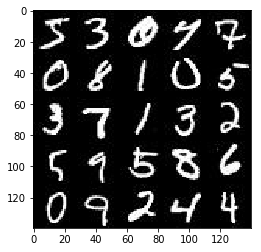

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

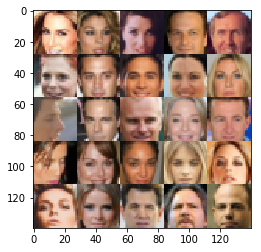

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input")
    z_data = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_data")
    lr = tf.placeholder(dtype=tf.float32, shape=(), name="learnings_rate")
    
    return input_, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.1, name=None):
    return tf.maximum(x*alpha, x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # images have a shape of 28x28xchannels
        conv = tf.layers.conv2d(images, filters=8, kernel_size=(7, 7), strides=(1, 1), padding="same", activation=None)
        relu = leaky_relu(conv)
        
        # 28x28x8
        conv = tf.layers.conv2d(relu, filters=16, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        relu = leaky_relu(conv)
        
        # 14x14x16
        conv = tf.layers.conv2d(conv, filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        relu = leaky_relu(conv)
        
        # 7x7x64
        flat = tf.reshape(relu, shape=(-1, 7*7*64))
        conn = tf.layers.dense(flat, 512)
        conn_relu = leaky_relu(conn)
        
        # 512
        conn = tf.layers.dense(conn_relu, 256)
        conn_relu = leaky_relu(conn_relu)
        
        # 256
        logit = tf.layers.dense(conn_relu, 1)
        out = tf.sigmoid(logit)
        
    return out, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        conn = tf.layers.dense(z, 512)
        relu = leaky_relu(conn)
        
        # 512
        conn = tf.layers.dense(relu, 7*7*64)
        conn_bn = tf.layers.batch_normalization(conn, training=is_train)
        conn_relu = leaky_relu(conn_bn)
        
        imagey = tf.reshape(conn_relu, shape=(-1, 7, 7, 128))
        
        # 7x7x128
        conv = tf.layers.conv2d_transpose(imagey, filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        conv_bn = tf.layers.batch_normalization(conv, training=is_train)
        conv_relu = leaky_relu(conv_bn)
        
        # 14x14x64
        conv = tf.layers.conv2d_transpose(conv_relu, filters=32, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        conv_bn = tf.layers.batch_normalization(conv, training=is_train)
        conv_relu = leaky_relu(conv_bn)
        
        # 28x28x32
        conv = tf.layers.conv2d_transpose(conv_relu, filters=16, kernel_size=(7, 7), strides=(1, 1), padding="same", activation=None)
        conv_bn = tf.layers.batch_normalization(conv, training=is_train)
        conv_relu = leaky_relu(conv_bn)
        
        # 28x28x16
        conv = tf.layers.conv2d_transpose(conv_relu, filters=out_channel_dim, kernel_size=(7, 7), strides=(1, 1), padding="same", activation=None)
        
        # 28x28xout_channel_dim
        out = tf.tanh(conv)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False)
    disc_fake_out, disc_fake_logits = discriminator(input_fake, reuse=True)
    
    loss = lambda **kwargs: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(**kwargs))
    
    disc_real_loss = loss(logits=disc_real_logits, labels=tf.ones_like(disc_real_out))
    disc_fake_loss = loss(logits=disc_fake_logits, labels=tf.zeros_like(disc_fake_out))
    disc_loss = disc_real_loss + disc_fake_loss
    
    gen_loss = loss(logits=disc_fake_logits, labels=tf.ones_like(disc_fake_out))
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def minimize_with_clip(optimizer, loss, var_list):
    # Gradient Clipping
    gradients = optimizer.compute_gradients(loss, var_list=var_list)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)
    
    return train_op

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable = tf.trainable_variables()
    disc_vars = [var for var in trainable if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainable if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = minimize_with_clip(
            tf.train.AdamOptimizer(learning_rate, beta1=beta1), loss=d_loss, var_list=disc_vars)
        gen_optimizer = minimize_with_clip(
            tf.train.AdamOptimizer(learning_rate, beta1=beta1), loss=g_loss, var_list=gen_vars)

    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.figure(figsize=(8, 8))
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
run_i = 0

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    global run_i
    run_i += 1
    
    # Build model.
    nr_inputs, image_width, image_height, image_channels = data_shape

    input_, z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_, z_data, image_channels)
    discriminator_optimizer, generator_optimizer = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    # Fixed sample inputs.
    nr_samples = 128

    # Train network.
    saver = tf.train.Saver()
    
    batch_i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_i += 1
                
                for i in range(3):
                    z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    feed = {input_: batch_images, z_data: z_batch, lr: learning_rate}

                    sess.run([discriminator_optimizer,generator_optimizer], feed_dict=feed)

                if batch_i % 50 == 0:
                    discriminator_train_loss, generator_train_loss = sess.run([discriminator_loss, generator_loss], feed_dict=feed)
                    
                    print("Epoch {}, batch {}: discriminator loss {:.4f}, generator loss {:.4f}".format(
                        epoch_i, batch_i, discriminator_train_loss, generator_train_loss))
                    
                if batch_i % 500 == 0:
                    show_generator_output(sess, nr_samples, z_data, image_channels, data_image_mode)
                    
                    
        saver.save(sess, "./checkpoints/{}.ckpt".format(run_i))
        
        show_generator_output(sess, nr_samples, z_data, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0, batch 50: discriminator loss 1.2766, generator loss 0.5931
Epoch 0, batch 100: discriminator loss 1.0689, generator loss 0.9589
Epoch 0, batch 150: discriminator loss 1.0594, generator loss 0.7402
Epoch 0, batch 200: discriminator loss 1.2516, generator loss 0.5341
Epoch 0, batch 250: discriminator loss 1.0765, generator loss 0.6295
Epoch 0, batch 300: discriminator loss 0.7869, generator loss 1.7099
Epoch 0, batch 350: discriminator loss 0.6568, generator loss 1.8424
Epoch 0, batch 400: discriminator loss 0.7551, generator loss 1.2094
Epoch 0, batch 450: discriminator loss 1.0380, generator loss 0.6911
Epoch 0, batch 500: discriminator loss 0.5932, generator loss 1.8155


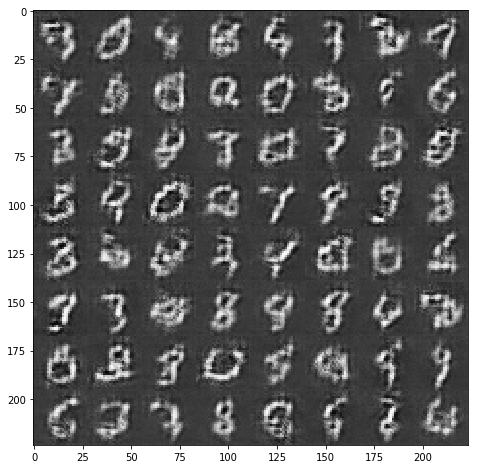

Epoch 0, batch 550: discriminator loss 1.0825, generator loss 1.0638
Epoch 0, batch 600: discriminator loss 1.4449, generator loss 2.1859
Epoch 0, batch 650: discriminator loss 0.9564, generator loss 1.7630
Epoch 0, batch 700: discriminator loss 0.7046, generator loss 2.3160
Epoch 0, batch 750: discriminator loss 0.8998, generator loss 2.1785
Epoch 0, batch 800: discriminator loss 0.7747, generator loss 2.3255
Epoch 0, batch 850: discriminator loss 1.0457, generator loss 0.6913
Epoch 0, batch 900: discriminator loss 0.8837, generator loss 1.0562
Epoch 0, batch 950: discriminator loss 0.6630, generator loss 1.1822
Epoch 0, batch 1000: discriminator loss 0.8232, generator loss 1.1282


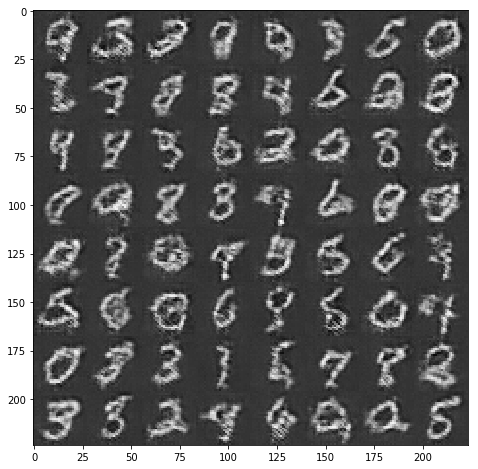

Epoch 0, batch 1050: discriminator loss 0.6946, generator loss 1.2674
Epoch 0, batch 1100: discriminator loss 0.7080, generator loss 1.3727
Epoch 0, batch 1150: discriminator loss 1.0792, generator loss 0.8872
Epoch 0, batch 1200: discriminator loss 0.6736, generator loss 1.2720
Epoch 0, batch 1250: discriminator loss 0.9913, generator loss 0.7202
Epoch 0, batch 1300: discriminator loss 0.8413, generator loss 1.1520
Epoch 0, batch 1350: discriminator loss 0.5846, generator loss 1.3150
Epoch 0, batch 1400: discriminator loss 0.7148, generator loss 1.0671
Epoch 0, batch 1450: discriminator loss 0.8829, generator loss 1.0917
Epoch 0, batch 1500: discriminator loss 1.0536, generator loss 0.6370


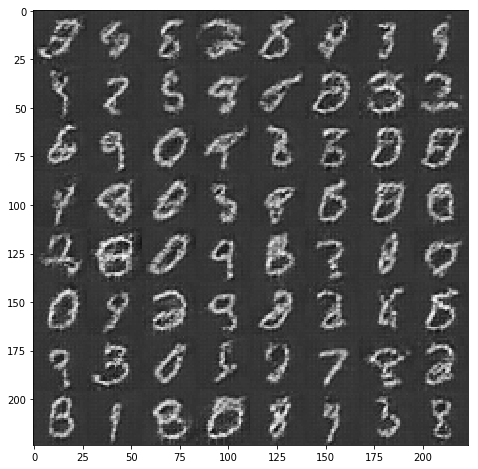

Epoch 0, batch 1550: discriminator loss 0.7863, generator loss 1.1986
Epoch 0, batch 1600: discriminator loss 0.6692, generator loss 1.0937
Epoch 0, batch 1650: discriminator loss 1.0344, generator loss 0.7933
Epoch 0, batch 1700: discriminator loss 0.7300, generator loss 1.0994
Epoch 0, batch 1750: discriminator loss 1.2801, generator loss 1.0727
Epoch 0, batch 1800: discriminator loss 0.7837, generator loss 0.9038
Epoch 0, batch 1850: discriminator loss 0.7208, generator loss 1.4143
Epoch 0, batch 1900: discriminator loss 0.4652, generator loss 1.6041
Epoch 0, batch 1950: discriminator loss 0.6161, generator loss 1.3798
Epoch 0, batch 2000: discriminator loss 0.6993, generator loss 1.2286


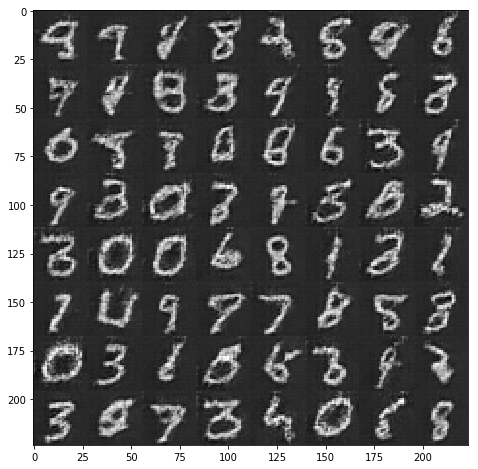

Epoch 0, batch 2050: discriminator loss 0.6191, generator loss 1.9762
Epoch 0, batch 2100: discriminator loss 0.5683, generator loss 1.6160
Epoch 0, batch 2150: discriminator loss 0.7212, generator loss 1.6604
Epoch 0, batch 2200: discriminator loss 0.5716, generator loss 1.4233
Epoch 0, batch 2250: discriminator loss 1.1243, generator loss 0.8868
Epoch 0, batch 2300: discriminator loss 0.5315, generator loss 1.4605
Epoch 0, batch 2350: discriminator loss 0.7629, generator loss 0.8821
Epoch 0, batch 2400: discriminator loss 0.7081, generator loss 1.6640
Epoch 0, batch 2450: discriminator loss 0.6077, generator loss 1.3681
Epoch 0, batch 2500: discriminator loss 0.6441, generator loss 1.5267


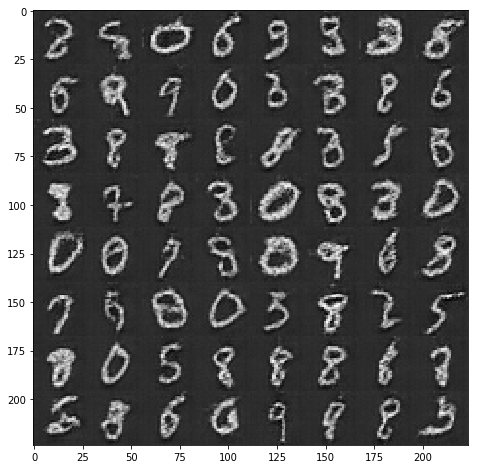

Epoch 0, batch 2550: discriminator loss 0.6476, generator loss 1.6843
Epoch 0, batch 2600: discriminator loss 0.4961, generator loss 1.4807
Epoch 0, batch 2650: discriminator loss 0.8114, generator loss 1.5223
Epoch 0, batch 2700: discriminator loss 0.7122, generator loss 1.3536
Epoch 0, batch 2750: discriminator loss 0.4963, generator loss 1.7088
Epoch 0, batch 2800: discriminator loss 0.9720, generator loss 0.9853
Epoch 0, batch 2850: discriminator loss 0.7679, generator loss 1.0736
Epoch 0, batch 2900: discriminator loss 0.5880, generator loss 1.2470
Epoch 0, batch 2950: discriminator loss 0.8312, generator loss 1.5155
Epoch 0, batch 3000: discriminator loss 0.6342, generator loss 1.2911


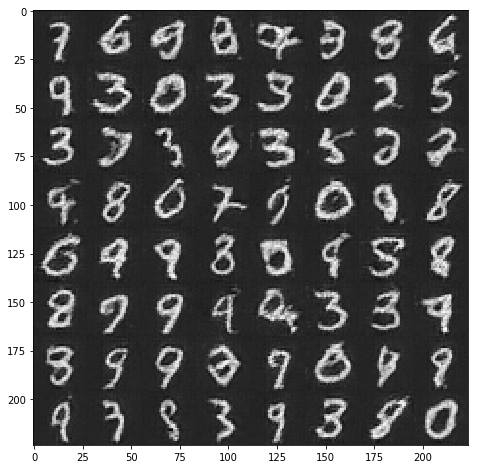

Epoch 0, batch 3050: discriminator loss 0.8962, generator loss 1.4065
Epoch 0, batch 3100: discriminator loss 0.9011, generator loss 0.8195
Epoch 0, batch 3150: discriminator loss 0.7192, generator loss 2.0986
Epoch 0, batch 3200: discriminator loss 0.5942, generator loss 1.5842
Epoch 0, batch 3250: discriminator loss 0.5711, generator loss 1.5282
Epoch 0, batch 3300: discriminator loss 0.4905, generator loss 1.4912
Epoch 0, batch 3350: discriminator loss 0.3380, generator loss 2.2512
Epoch 0, batch 3400: discriminator loss 0.5513, generator loss 1.6094
Epoch 0, batch 3450: discriminator loss 0.4681, generator loss 1.8359
Epoch 0, batch 3500: discriminator loss 0.5901, generator loss 1.5575


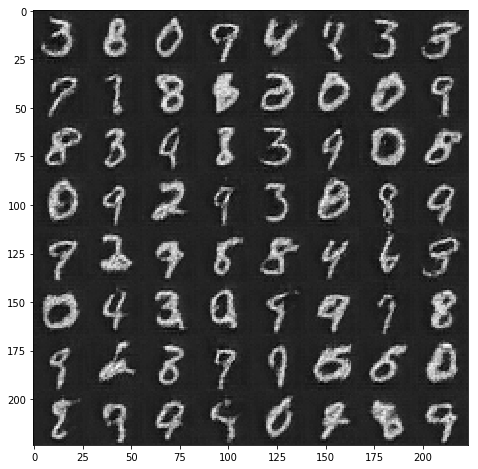

Epoch 0, batch 3550: discriminator loss 0.5540, generator loss 1.9828
Epoch 0, batch 3600: discriminator loss 0.5518, generator loss 1.5217
Epoch 0, batch 3650: discriminator loss 0.5263, generator loss 1.5106
Epoch 0, batch 3700: discriminator loss 0.7930, generator loss 1.3181
Epoch 0, batch 3750: discriminator loss 0.3921, generator loss 1.7447
Epoch 1, batch 3800: discriminator loss 0.5642, generator loss 2.0899
Epoch 1, batch 3850: discriminator loss 0.6229, generator loss 2.2543
Epoch 1, batch 3900: discriminator loss 0.3850, generator loss 1.6896
Epoch 1, batch 3950: discriminator loss 0.5766, generator loss 1.1122
Epoch 1, batch 4000: discriminator loss 0.6581, generator loss 1.7060


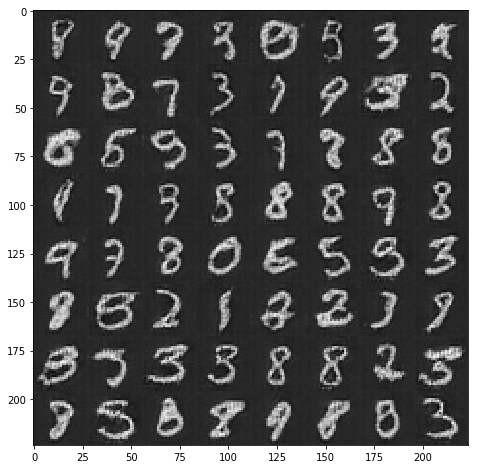

Epoch 1, batch 4050: discriminator loss 0.5278, generator loss 1.8236
Epoch 1, batch 4100: discriminator loss 0.5304, generator loss 2.5321
Epoch 1, batch 4150: discriminator loss 0.6085, generator loss 1.5200
Epoch 1, batch 4200: discriminator loss 0.5759, generator loss 1.2879
Epoch 1, batch 4250: discriminator loss 0.7943, generator loss 1.2780
Epoch 1, batch 4300: discriminator loss 0.8041, generator loss 1.2440
Epoch 1, batch 4350: discriminator loss 0.7618, generator loss 1.5130
Epoch 1, batch 4400: discriminator loss 0.6129, generator loss 1.0465
Epoch 1, batch 4450: discriminator loss 0.6487, generator loss 1.1825
Epoch 1, batch 4500: discriminator loss 0.7488, generator loss 1.0658


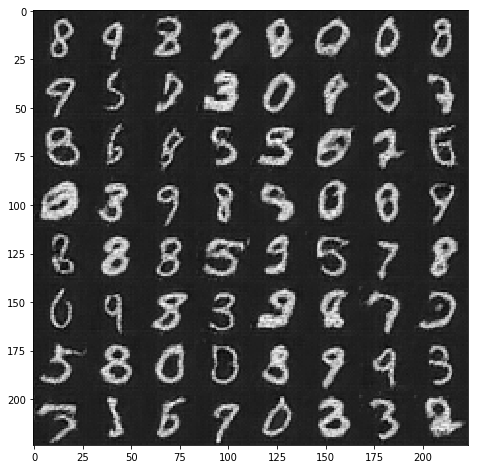

Epoch 1, batch 4550: discriminator loss 0.5740, generator loss 1.3020
Epoch 1, batch 4600: discriminator loss 0.8558, generator loss 1.1322
Epoch 1, batch 4650: discriminator loss 0.6555, generator loss 1.1408
Epoch 1, batch 4700: discriminator loss 0.6276, generator loss 1.3165
Epoch 1, batch 4750: discriminator loss 0.6238, generator loss 1.3192
Epoch 1, batch 4800: discriminator loss 0.3198, generator loss 1.8623
Epoch 1, batch 4850: discriminator loss 0.7579, generator loss 2.1409
Epoch 1, batch 4900: discriminator loss 0.7268, generator loss 1.0416
Epoch 1, batch 4950: discriminator loss 0.8331, generator loss 1.3869
Epoch 1, batch 5000: discriminator loss 0.6199, generator loss 1.3184


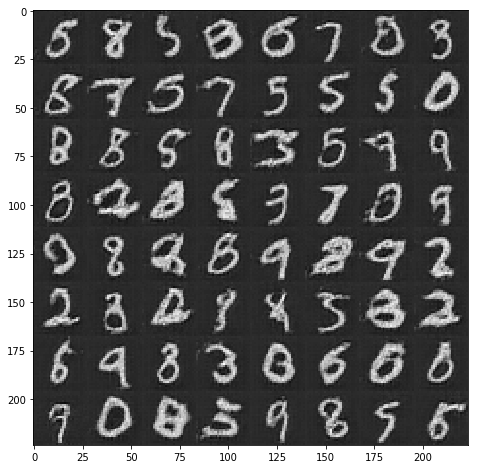

Epoch 1, batch 5050: discriminator loss 0.4748, generator loss 1.4889
Epoch 1, batch 5100: discriminator loss 0.6239, generator loss 1.8077
Epoch 1, batch 5150: discriminator loss 0.4244, generator loss 1.7158
Epoch 1, batch 5200: discriminator loss 0.6053, generator loss 1.7648
Epoch 1, batch 5250: discriminator loss 0.4250, generator loss 1.8278
Epoch 1, batch 5300: discriminator loss 0.4699, generator loss 1.6015
Epoch 1, batch 5350: discriminator loss 0.4660, generator loss 1.5111
Epoch 1, batch 5400: discriminator loss 0.6646, generator loss 1.3388
Epoch 1, batch 5450: discriminator loss 0.5114, generator loss 1.4022
Epoch 1, batch 5500: discriminator loss 0.8881, generator loss 2.6878


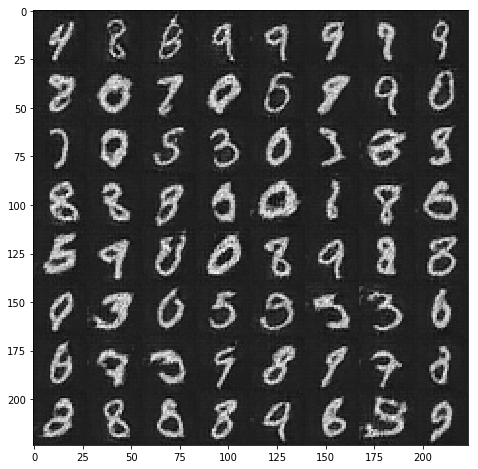

Epoch 1, batch 5550: discriminator loss 0.5658, generator loss 2.2789
Epoch 1, batch 5600: discriminator loss 0.4400, generator loss 1.6204
Epoch 1, batch 5650: discriminator loss 0.3787, generator loss 1.9401
Epoch 1, batch 5700: discriminator loss 0.7055, generator loss 1.1652
Epoch 1, batch 5750: discriminator loss 0.3641, generator loss 2.2340
Epoch 1, batch 5800: discriminator loss 0.3191, generator loss 2.2532
Epoch 1, batch 5850: discriminator loss 0.4908, generator loss 2.1076
Epoch 1, batch 5900: discriminator loss 0.3343, generator loss 1.7168
Epoch 1, batch 5950: discriminator loss 0.4163, generator loss 2.4151
Epoch 1, batch 6000: discriminator loss 0.8271, generator loss 1.0804


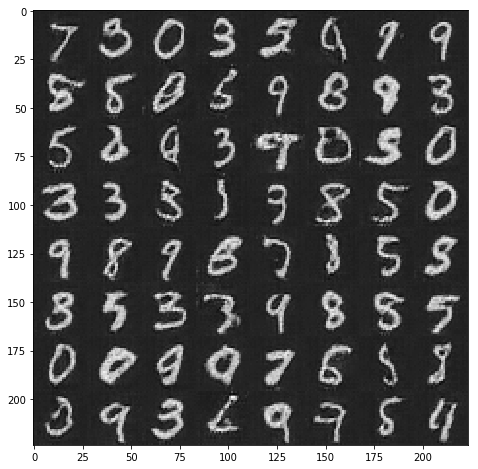

Epoch 1, batch 6050: discriminator loss 0.4686, generator loss 1.7548
Epoch 1, batch 6100: discriminator loss 0.4008, generator loss 1.4939
Epoch 1, batch 6150: discriminator loss 0.4009, generator loss 1.5493
Epoch 1, batch 6200: discriminator loss 0.5077, generator loss 1.5932
Epoch 1, batch 6250: discriminator loss 0.3645, generator loss 1.9202
Epoch 1, batch 6300: discriminator loss 0.4615, generator loss 1.4178
Epoch 1, batch 6350: discriminator loss 0.3247, generator loss 2.1441
Epoch 1, batch 6400: discriminator loss 0.4932, generator loss 1.7156
Epoch 1, batch 6450: discriminator loss 0.4571, generator loss 1.8830
Epoch 1, batch 6500: discriminator loss 0.3359, generator loss 1.6579


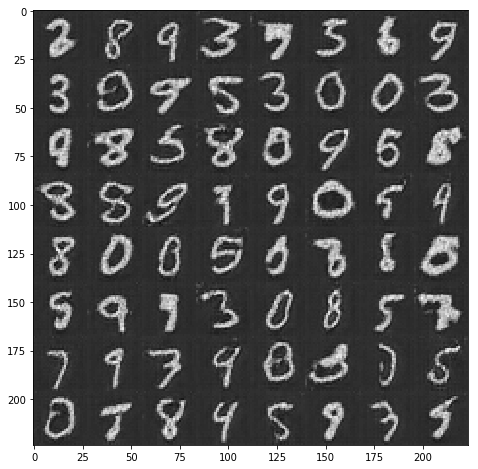

Epoch 1, batch 6550: discriminator loss 0.4431, generator loss 1.5079
Epoch 1, batch 6600: discriminator loss 0.7640, generator loss 1.4969
Epoch 1, batch 6650: discriminator loss 0.6330, generator loss 1.3011
Epoch 1, batch 6700: discriminator loss 0.5216, generator loss 1.3523
Epoch 1, batch 6750: discriminator loss 0.4545, generator loss 1.7067
Epoch 1, batch 6800: discriminator loss 0.3610, generator loss 2.1920
Epoch 1, batch 6850: discriminator loss 0.7312, generator loss 1.1008
Epoch 1, batch 6900: discriminator loss 0.6214, generator loss 1.2387
Epoch 1, batch 6950: discriminator loss 0.5012, generator loss 1.2203
Epoch 1, batch 7000: discriminator loss 0.4023, generator loss 1.3383


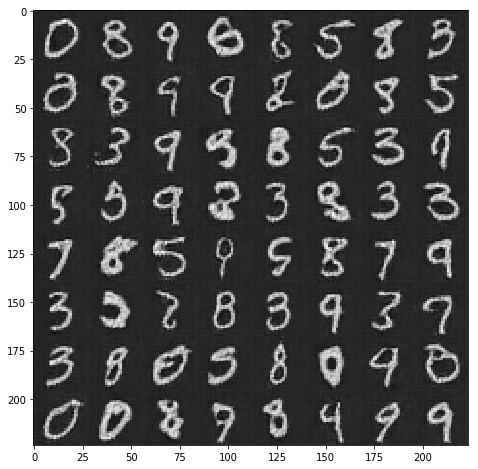

Epoch 1, batch 7050: discriminator loss 0.3493, generator loss 2.0192
Epoch 1, batch 7100: discriminator loss 0.2013, generator loss 2.3522
Epoch 1, batch 7150: discriminator loss 0.3234, generator loss 2.0513
Epoch 1, batch 7200: discriminator loss 0.2755, generator loss 2.3685
Epoch 1, batch 7250: discriminator loss 0.4284, generator loss 1.5452
Epoch 1, batch 7300: discriminator loss 0.4634, generator loss 2.0644
Epoch 1, batch 7350: discriminator loss 0.4363, generator loss 1.8368
Epoch 1, batch 7400: discriminator loss 0.4243, generator loss 1.8780
Epoch 1, batch 7450: discriminator loss 0.6399, generator loss 1.3506
Epoch 1, batch 7500: discriminator loss 0.3703, generator loss 1.9605


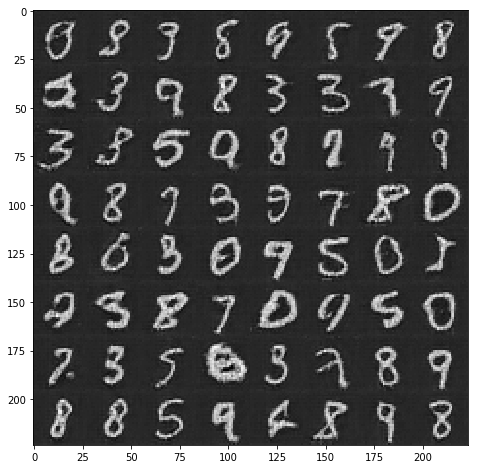

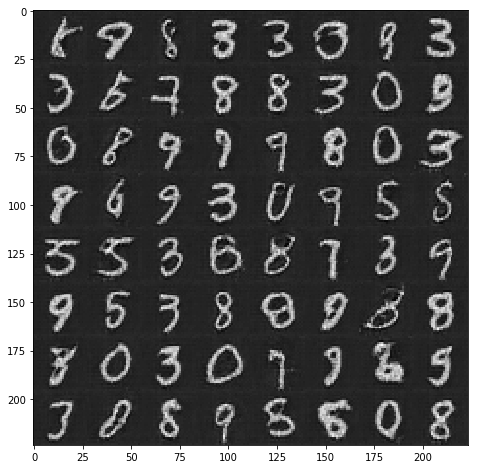

In [31]:
batch_size = 16
z_dim = 64
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0, batch 50: discriminator loss 0.5584, generator loss 1.3824
Epoch 0, batch 100: discriminator loss 0.6551, generator loss 1.1012
Epoch 0, batch 150: discriminator loss 0.9620, generator loss 1.2930
Epoch 0, batch 200: discriminator loss 0.4011, generator loss 1.4177
Epoch 0, batch 250: discriminator loss 0.5616, generator loss 1.2295
Epoch 0, batch 300: discriminator loss 0.6160, generator loss 1.6045
Epoch 0, batch 350: discriminator loss 1.3148, generator loss 0.5215
Epoch 0, batch 400: discriminator loss 0.1168, generator loss 4.9882
Epoch 0, batch 450: discriminator loss 0.4614, generator loss 5.2433
Epoch 0, batch 500: discriminator loss 0.5268, generator loss 1.6040


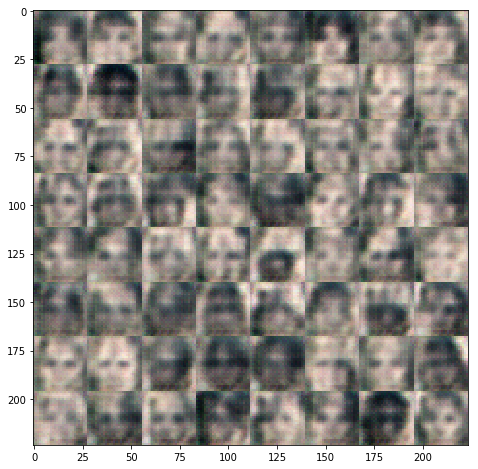

Epoch 0, batch 550: discriminator loss 0.4373, generator loss 1.8942
Epoch 0, batch 600: discriminator loss 0.6192, generator loss 1.0577
Epoch 0, batch 650: discriminator loss 0.4336, generator loss 2.0873
Epoch 0, batch 700: discriminator loss 1.1764, generator loss 0.8168
Epoch 0, batch 750: discriminator loss 0.3937, generator loss 2.6152
Epoch 0, batch 800: discriminator loss 0.6377, generator loss 1.4428
Epoch 0, batch 850: discriminator loss 0.9636, generator loss 1.0387
Epoch 0, batch 900: discriminator loss 0.9649, generator loss 1.2697
Epoch 0, batch 950: discriminator loss 0.8777, generator loss 1.1946
Epoch 0, batch 1000: discriminator loss 0.7491, generator loss 1.4391


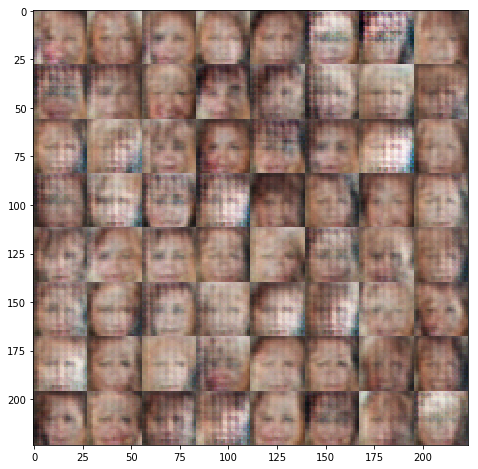

Epoch 0, batch 1050: discriminator loss 0.7830, generator loss 1.1537
Epoch 0, batch 1100: discriminator loss 0.9222, generator loss 0.7806
Epoch 0, batch 1150: discriminator loss 0.7799, generator loss 1.3455
Epoch 0, batch 1200: discriminator loss 0.4398, generator loss 1.5258
Epoch 0, batch 1250: discriminator loss 0.7138, generator loss 1.0564
Epoch 0, batch 1300: discriminator loss 0.6199, generator loss 1.3873
Epoch 0, batch 1350: discriminator loss 0.4853, generator loss 1.6779
Epoch 0, batch 1400: discriminator loss 0.6148, generator loss 1.4890
Epoch 0, batch 1450: discriminator loss 0.9261, generator loss 0.7814
Epoch 0, batch 1500: discriminator loss 0.7851, generator loss 0.9399


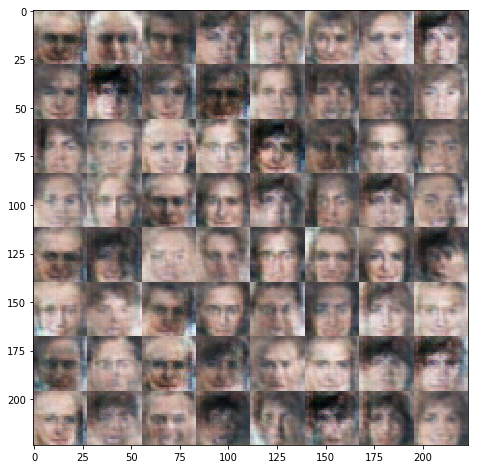

Epoch 0, batch 1550: discriminator loss 0.3939, generator loss 3.1993
Epoch 0, batch 1600: discriminator loss 0.7007, generator loss 1.2425
Epoch 0, batch 1650: discriminator loss 1.0151, generator loss 0.8092
Epoch 0, batch 1700: discriminator loss 0.9333, generator loss 0.8907
Epoch 0, batch 1750: discriminator loss 0.4652, generator loss 1.3486
Epoch 0, batch 1800: discriminator loss 0.5465, generator loss 1.4408
Epoch 0, batch 1850: discriminator loss 0.6724, generator loss 1.2620
Epoch 0, batch 1900: discriminator loss 1.0388, generator loss 1.0603
Epoch 0, batch 1950: discriminator loss 0.5032, generator loss 1.2115
Epoch 0, batch 2000: discriminator loss 0.6624, generator loss 1.0929


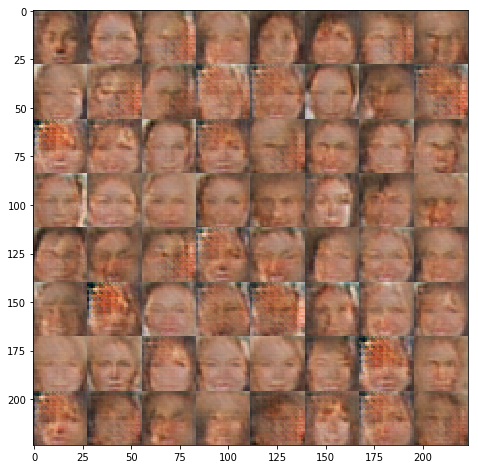

Epoch 0, batch 2050: discriminator loss 0.8581, generator loss 0.8055
Epoch 0, batch 2100: discriminator loss 0.8905, generator loss 0.9063
Epoch 0, batch 2150: discriminator loss 0.6022, generator loss 1.2484
Epoch 0, batch 2200: discriminator loss 0.8153, generator loss 0.9518
Epoch 0, batch 2250: discriminator loss 0.7960, generator loss 0.8714
Epoch 0, batch 2300: discriminator loss 0.6796, generator loss 1.2482
Epoch 0, batch 2350: discriminator loss 0.8541, generator loss 1.0427
Epoch 0, batch 2400: discriminator loss 0.3918, generator loss 1.5248
Epoch 0, batch 2450: discriminator loss 0.6934, generator loss 1.1379
Epoch 0, batch 2500: discriminator loss 0.7762, generator loss 0.8752


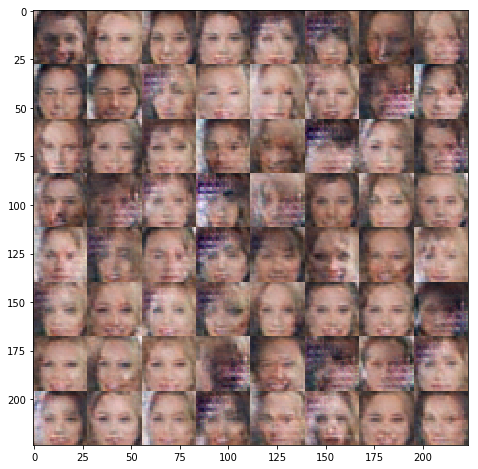

Epoch 0, batch 2550: discriminator loss 1.1213, generator loss 0.7132
Epoch 0, batch 2600: discriminator loss 0.6798, generator loss 1.2944
Epoch 0, batch 2650: discriminator loss 0.7485, generator loss 1.2158
Epoch 0, batch 2700: discriminator loss 1.1490, generator loss 0.7062
Epoch 0, batch 2750: discriminator loss 0.5806, generator loss 1.5223
Epoch 0, batch 2800: discriminator loss 0.8016, generator loss 1.0246
Epoch 0, batch 2850: discriminator loss 0.6572, generator loss 1.2886
Epoch 0, batch 2900: discriminator loss 0.7537, generator loss 1.0527
Epoch 0, batch 2950: discriminator loss 0.7186, generator loss 1.8126
Epoch 0, batch 3000: discriminator loss 0.6060, generator loss 1.3441


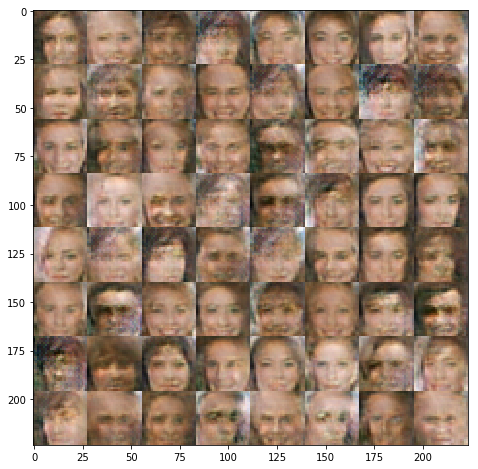

Epoch 0, batch 3050: discriminator loss 0.7273, generator loss 0.9032
Epoch 0, batch 3100: discriminator loss 0.4898, generator loss 2.8682
Epoch 0, batch 3150: discriminator loss 0.6997, generator loss 1.0392
Epoch 0, batch 3200: discriminator loss 0.6134, generator loss 1.6987
Epoch 0, batch 3250: discriminator loss 0.7041, generator loss 1.1768
Epoch 0, batch 3300: discriminator loss 0.7049, generator loss 1.4289
Epoch 0, batch 3350: discriminator loss 0.4139, generator loss 1.5492
Epoch 0, batch 3400: discriminator loss 0.5835, generator loss 1.2839
Epoch 0, batch 3450: discriminator loss 0.7960, generator loss 0.8973
Epoch 0, batch 3500: discriminator loss 0.6004, generator loss 1.0675


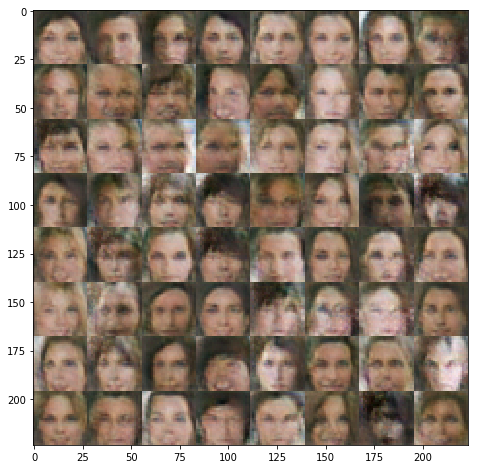

Epoch 0, batch 3550: discriminator loss 0.8088, generator loss 0.9337
Epoch 0, batch 3600: discriminator loss 0.5005, generator loss 1.3389
Epoch 0, batch 3650: discriminator loss 1.1816, generator loss 0.7303
Epoch 0, batch 3700: discriminator loss 0.6600, generator loss 1.0464
Epoch 0, batch 3750: discriminator loss 0.6001, generator loss 1.3824
Epoch 0, batch 3800: discriminator loss 0.8370, generator loss 0.9617
Epoch 0, batch 3850: discriminator loss 0.9728, generator loss 0.8280
Epoch 0, batch 3900: discriminator loss 0.6196, generator loss 1.2034
Epoch 0, batch 3950: discriminator loss 0.8447, generator loss 0.8460
Epoch 0, batch 4000: discriminator loss 0.5030, generator loss 1.3868


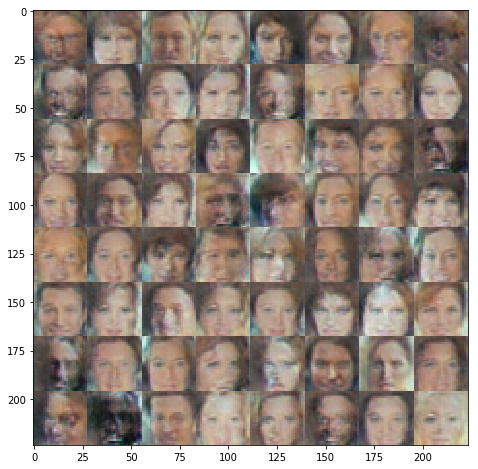

Epoch 0, batch 4050: discriminator loss 0.4845, generator loss 1.4564
Epoch 0, batch 4100: discriminator loss 0.6990, generator loss 1.2534
Epoch 0, batch 4150: discriminator loss 0.6277, generator loss 1.4000
Epoch 0, batch 4200: discriminator loss 0.3484, generator loss 2.1043
Epoch 0, batch 4250: discriminator loss 1.2630, generator loss 0.6871
Epoch 0, batch 4300: discriminator loss 0.5411, generator loss 1.1569
Epoch 0, batch 4350: discriminator loss 0.5386, generator loss 1.1199
Epoch 0, batch 4400: discriminator loss 0.7662, generator loss 0.9968
Epoch 0, batch 4450: discriminator loss 0.6622, generator loss 1.5684
Epoch 0, batch 4500: discriminator loss 0.7707, generator loss 1.0098


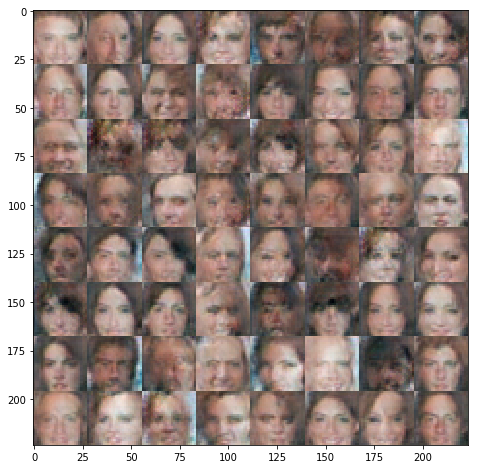

Epoch 0, batch 4550: discriminator loss 0.5629, generator loss 1.2817
Epoch 0, batch 4600: discriminator loss 0.5490, generator loss 1.1200
Epoch 0, batch 4650: discriminator loss 0.5034, generator loss 1.2102
Epoch 0, batch 4700: discriminator loss 0.5261, generator loss 1.1824
Epoch 0, batch 4750: discriminator loss 0.7851, generator loss 0.8242
Epoch 0, batch 4800: discriminator loss 0.3062, generator loss 1.7343
Epoch 0, batch 4850: discriminator loss 0.6326, generator loss 1.1271
Epoch 0, batch 4900: discriminator loss 0.6274, generator loss 1.2122
Epoch 0, batch 4950: discriminator loss 0.4180, generator loss 1.5955
Epoch 0, batch 5000: discriminator loss 0.6427, generator loss 1.0229


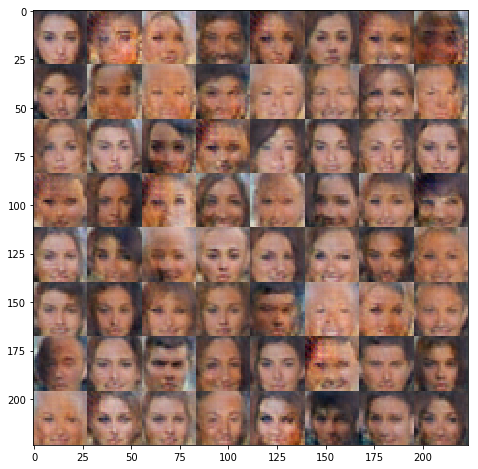

Epoch 0, batch 5050: discriminator loss 0.7031, generator loss 0.9325
Epoch 0, batch 5100: discriminator loss 0.7027, generator loss 1.0644
Epoch 0, batch 5150: discriminator loss 0.6256, generator loss 1.4617
Epoch 0, batch 5200: discriminator loss 0.7043, generator loss 1.0590
Epoch 0, batch 5250: discriminator loss 0.4348, generator loss 1.6823
Epoch 0, batch 5300: discriminator loss 1.5596, generator loss 0.5811
Epoch 0, batch 5350: discriminator loss 0.4508, generator loss 1.3536
Epoch 0, batch 5400: discriminator loss 0.5054, generator loss 1.5117
Epoch 0, batch 5450: discriminator loss 0.7703, generator loss 0.7916
Epoch 0, batch 5500: discriminator loss 0.4930, generator loss 1.2278


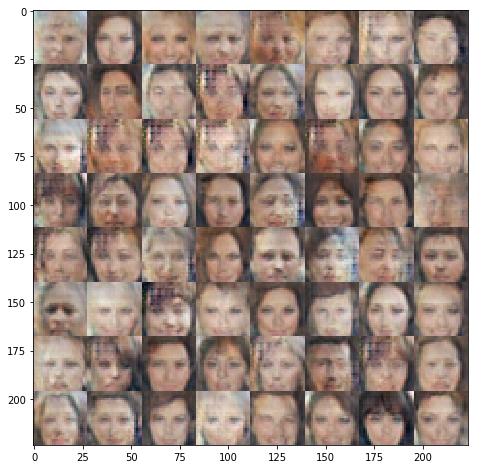

Epoch 0, batch 5550: discriminator loss 0.6705, generator loss 1.2282
Epoch 0, batch 5600: discriminator loss 0.5041, generator loss 1.5026
Epoch 0, batch 5650: discriminator loss 0.5582, generator loss 1.2448
Epoch 0, batch 5700: discriminator loss 0.5876, generator loss 1.4960
Epoch 0, batch 5750: discriminator loss 0.5408, generator loss 1.1939
Epoch 0, batch 5800: discriminator loss 0.5833, generator loss 1.3708
Epoch 0, batch 5850: discriminator loss 0.4382, generator loss 1.4732
Epoch 0, batch 5900: discriminator loss 0.5069, generator loss 1.3140
Epoch 0, batch 5950: discriminator loss 0.6641, generator loss 1.2401
Epoch 0, batch 6000: discriminator loss 0.6214, generator loss 1.5762


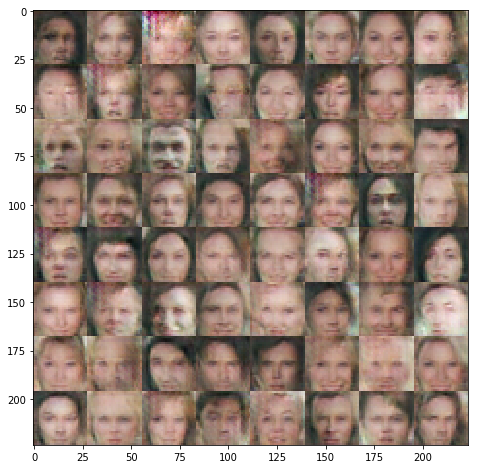

Epoch 0, batch 6050: discriminator loss 0.5454, generator loss 1.2281
Epoch 0, batch 6100: discriminator loss 0.4669, generator loss 1.1989
Epoch 0, batch 6150: discriminator loss 0.5796, generator loss 1.2732
Epoch 0, batch 6200: discriminator loss 0.9622, generator loss 1.0223
Epoch 0, batch 6250: discriminator loss 0.5948, generator loss 1.4275
Epoch 0, batch 6300: discriminator loss 0.4041, generator loss 1.3990
Epoch 0, batch 6350: discriminator loss 0.6246, generator loss 1.1069
Epoch 0, batch 6400: discriminator loss 0.5974, generator loss 1.2603
Epoch 0, batch 6450: discriminator loss 0.5876, generator loss 1.2514
Epoch 0, batch 6500: discriminator loss 0.8159, generator loss 0.7502


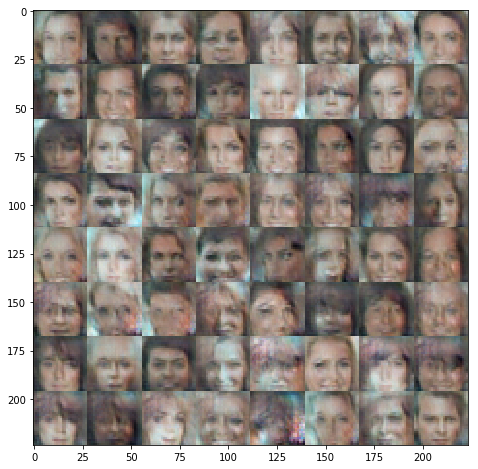

Epoch 0, batch 6550: discriminator loss 0.3274, generator loss 1.8334
Epoch 0, batch 6600: discriminator loss 0.3633, generator loss 1.8732
Epoch 0, batch 6650: discriminator loss 0.8619, generator loss 0.7960
Epoch 0, batch 6700: discriminator loss 0.8072, generator loss 0.8521
Epoch 0, batch 6750: discriminator loss 0.4455, generator loss 1.5184
Epoch 0, batch 6800: discriminator loss 0.6820, generator loss 1.1785
Epoch 0, batch 6850: discriminator loss 0.8508, generator loss 1.1208
Epoch 0, batch 6900: discriminator loss 0.4587, generator loss 1.4015
Epoch 0, batch 6950: discriminator loss 0.5919, generator loss 1.1563
Epoch 0, batch 7000: discriminator loss 0.4838, generator loss 1.5701


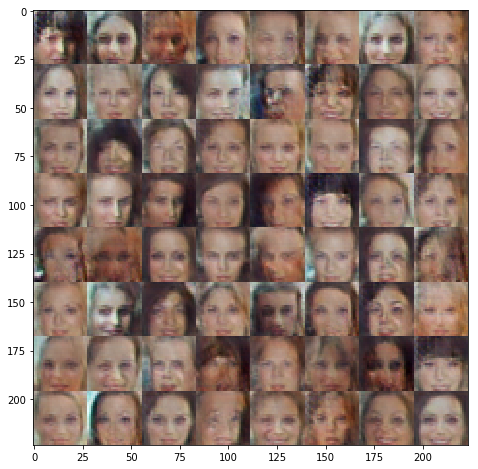

Epoch 0, batch 7050: discriminator loss 0.5227, generator loss 1.4150
Epoch 0, batch 7100: discriminator loss 0.6528, generator loss 1.0164
Epoch 0, batch 7150: discriminator loss 0.5150, generator loss 1.2814
Epoch 0, batch 7200: discriminator loss 0.3973, generator loss 1.4724
Epoch 0, batch 7250: discriminator loss 0.7879, generator loss 0.7868
Epoch 0, batch 7300: discriminator loss 0.4540, generator loss 1.2350
Epoch 0, batch 7350: discriminator loss 0.5048, generator loss 1.3759
Epoch 0, batch 7400: discriminator loss 0.4654, generator loss 1.4539
Epoch 0, batch 7450: discriminator loss 0.6174, generator loss 1.0584
Epoch 0, batch 7500: discriminator loss 0.8208, generator loss 0.8926


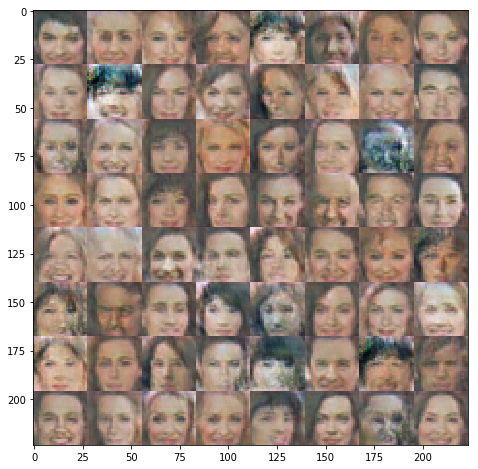

Epoch 0, batch 7550: discriminator loss 0.6477, generator loss 1.0136
Epoch 0, batch 7600: discriminator loss 0.6542, generator loss 1.0688
Epoch 0, batch 7650: discriminator loss 0.4766, generator loss 1.8932
Epoch 0, batch 7700: discriminator loss 0.8297, generator loss 0.8821
Epoch 0, batch 7750: discriminator loss 0.5319, generator loss 1.3730
Epoch 0, batch 7800: discriminator loss 0.6955, generator loss 1.0644
Epoch 0, batch 7850: discriminator loss 0.5224, generator loss 1.2192
Epoch 0, batch 7900: discriminator loss 0.4958, generator loss 1.0901
Epoch 0, batch 7950: discriminator loss 0.5691, generator loss 1.0037
Epoch 0, batch 8000: discriminator loss 0.5784, generator loss 1.3639


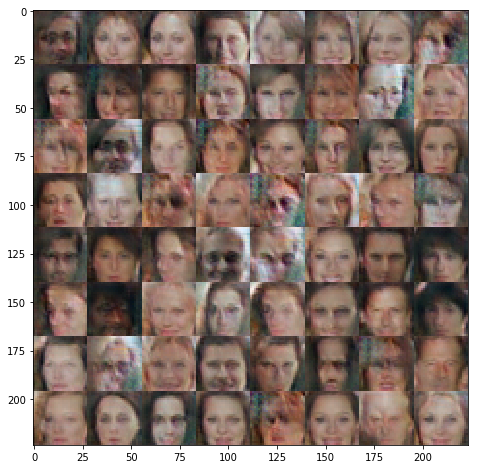

Epoch 0, batch 8050: discriminator loss 0.4441, generator loss 1.3792
Epoch 0, batch 8100: discriminator loss 0.6044, generator loss 1.6379
Epoch 0, batch 8150: discriminator loss 0.6030, generator loss 1.1842
Epoch 0, batch 8200: discriminator loss 0.4604, generator loss 1.3660
Epoch 0, batch 8250: discriminator loss 0.7460, generator loss 1.0191
Epoch 0, batch 8300: discriminator loss 0.5386, generator loss 1.3461
Epoch 0, batch 8350: discriminator loss 0.6353, generator loss 1.0372
Epoch 0, batch 8400: discriminator loss 0.4503, generator loss 1.2052
Epoch 0, batch 8450: discriminator loss 0.5884, generator loss 1.0849
Epoch 0, batch 8500: discriminator loss 0.3407, generator loss 1.7684


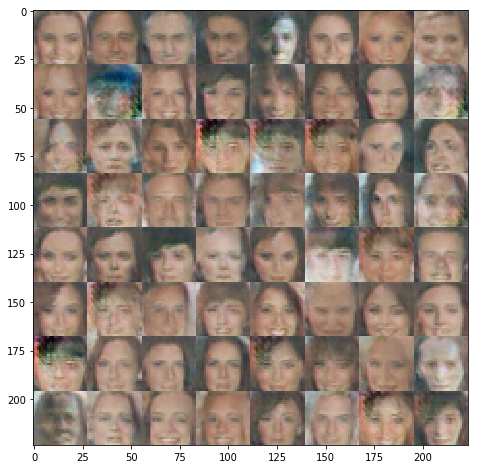

Epoch 0, batch 8550: discriminator loss 0.8632, generator loss 1.3783
Epoch 0, batch 8600: discriminator loss 0.3364, generator loss 1.8309
Epoch 0, batch 8650: discriminator loss 0.3660, generator loss 1.6319
Epoch 0, batch 8700: discriminator loss 0.8106, generator loss 1.0825
Epoch 0, batch 8750: discriminator loss 0.5930, generator loss 1.1369
Epoch 0, batch 8800: discriminator loss 0.5644, generator loss 1.2437
Epoch 0, batch 8850: discriminator loss 0.4900, generator loss 1.4205
Epoch 0, batch 8900: discriminator loss 0.5764, generator loss 1.3611
Epoch 0, batch 8950: discriminator loss 0.3781, generator loss 1.5758
Epoch 0, batch 9000: discriminator loss 0.6730, generator loss 1.4482


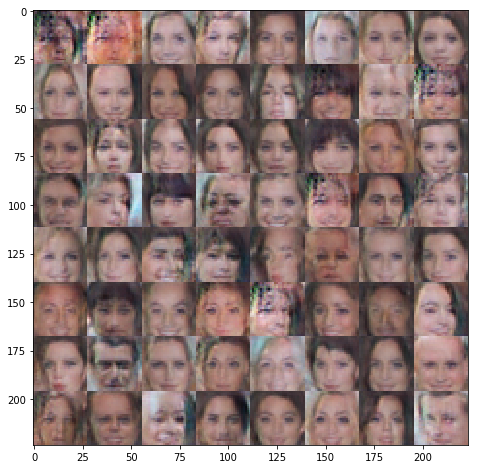

Epoch 0, batch 9050: discriminator loss 0.4003, generator loss 1.4680
Epoch 0, batch 9100: discriminator loss 0.7929, generator loss 1.3747
Epoch 0, batch 9150: discriminator loss 0.7025, generator loss 1.3046
Epoch 0, batch 9200: discriminator loss 0.4243, generator loss 1.5676
Epoch 0, batch 9250: discriminator loss 0.4848, generator loss 1.2075
Epoch 0, batch 9300: discriminator loss 0.6072, generator loss 1.3601
Epoch 0, batch 9350: discriminator loss 0.6751, generator loss 1.5748
Epoch 0, batch 9400: discriminator loss 0.5715, generator loss 1.3827
Epoch 0, batch 9450: discriminator loss 0.4883, generator loss 1.5160
Epoch 0, batch 9500: discriminator loss 0.7026, generator loss 1.1697


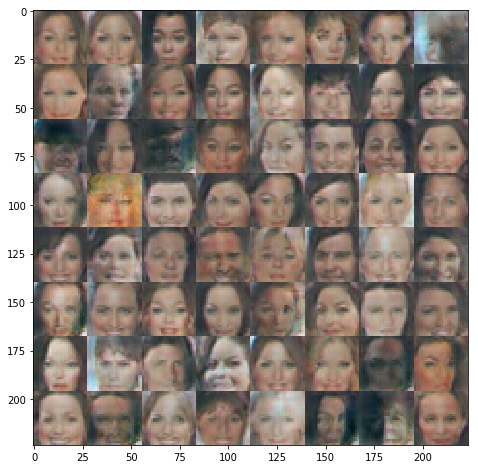

Epoch 0, batch 9550: discriminator loss 0.5892, generator loss 1.2029
Epoch 0, batch 9600: discriminator loss 3.0018, generator loss 0.7433
Epoch 0, batch 9650: discriminator loss 0.8236, generator loss 1.0179
Epoch 0, batch 9700: discriminator loss 0.5028, generator loss 1.3351
Epoch 0, batch 9750: discriminator loss 0.3100, generator loss 2.0646
Epoch 0, batch 9800: discriminator loss 0.6693, generator loss 1.0381
Epoch 0, batch 9850: discriminator loss 0.4122, generator loss 1.9096
Epoch 0, batch 9900: discriminator loss 0.7140, generator loss 1.0393
Epoch 0, batch 9950: discriminator loss 0.5223, generator loss 1.2463
Epoch 0, batch 10000: discriminator loss 0.6314, generator loss 1.0577


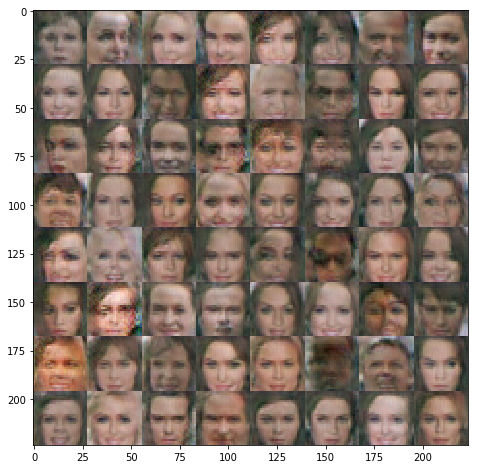

Epoch 0, batch 10050: discriminator loss 0.4265, generator loss 1.5043
Epoch 0, batch 10100: discriminator loss 0.2919, generator loss 2.4079
Epoch 0, batch 10150: discriminator loss 0.5006, generator loss 1.1794
Epoch 0, batch 10200: discriminator loss 0.3967, generator loss 1.4803
Epoch 0, batch 10250: discriminator loss 0.4796, generator loss 1.6213
Epoch 0, batch 10300: discriminator loss 0.3457, generator loss 1.5780
Epoch 0, batch 10350: discriminator loss 0.5847, generator loss 1.3059
Epoch 0, batch 10400: discriminator loss 0.3887, generator loss 1.4152
Epoch 0, batch 10450: discriminator loss 0.3571, generator loss 1.4999
Epoch 0, batch 10500: discriminator loss 0.3415, generator loss 1.6331


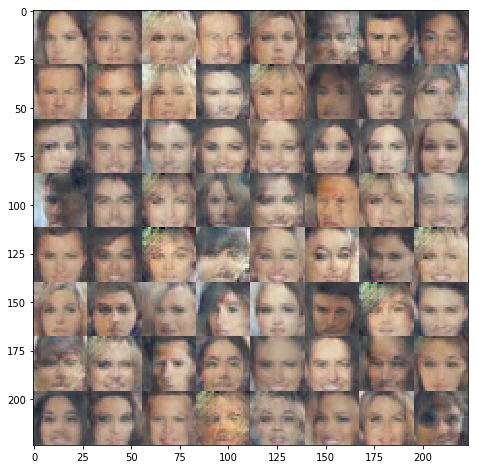

Epoch 0, batch 10550: discriminator loss 0.3618, generator loss 1.7691
Epoch 0, batch 10600: discriminator loss 0.8595, generator loss 1.0203
Epoch 0, batch 10650: discriminator loss 0.5718, generator loss 1.2046
Epoch 0, batch 10700: discriminator loss 0.7447, generator loss 1.2618
Epoch 0, batch 10750: discriminator loss 0.6887, generator loss 0.9877
Epoch 0, batch 10800: discriminator loss 0.4771, generator loss 1.2144
Epoch 0, batch 10850: discriminator loss 0.2679, generator loss 1.9055
Epoch 0, batch 10900: discriminator loss 0.4139, generator loss 1.3813
Epoch 0, batch 10950: discriminator loss 0.6444, generator loss 1.4710
Epoch 0, batch 11000: discriminator loss 0.4425, generator loss 1.3084


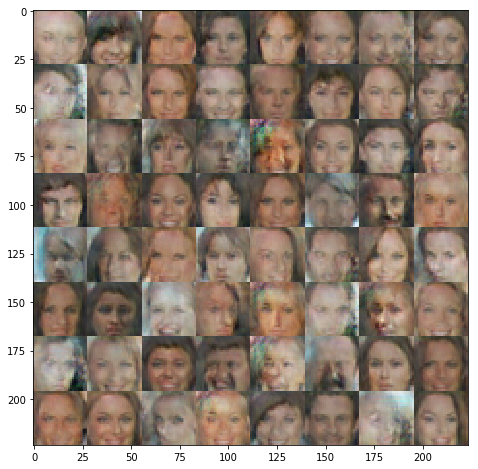

Epoch 0, batch 11050: discriminator loss 0.3340, generator loss 1.6059
Epoch 0, batch 11100: discriminator loss 0.5865, generator loss 1.1164
Epoch 0, batch 11150: discriminator loss 0.3568, generator loss 1.5547
Epoch 0, batch 11200: discriminator loss 0.4023, generator loss 1.2734
Epoch 0, batch 11250: discriminator loss 0.7971, generator loss 1.0334
Epoch 0, batch 11300: discriminator loss 0.3016, generator loss 1.5559
Epoch 0, batch 11350: discriminator loss 0.4648, generator loss 1.3417
Epoch 0, batch 11400: discriminator loss 0.2664, generator loss 2.0340
Epoch 0, batch 11450: discriminator loss 0.5039, generator loss 1.1560
Epoch 0, batch 11500: discriminator loss 0.9403, generator loss 0.7923


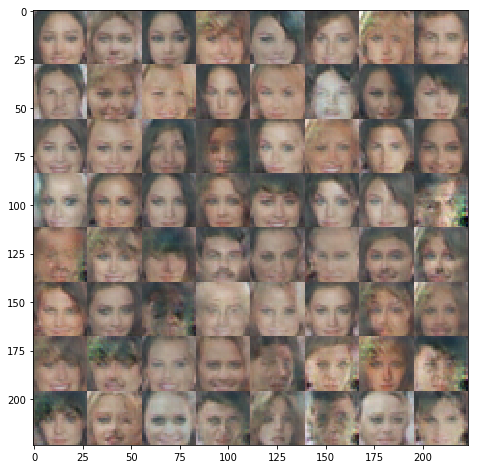

Epoch 0, batch 11550: discriminator loss 0.3869, generator loss 1.3603
Epoch 0, batch 11600: discriminator loss 0.5308, generator loss 1.7466
Epoch 0, batch 11650: discriminator loss 0.3603, generator loss 1.5094
Epoch 0, batch 11700: discriminator loss 0.2748, generator loss 1.9735
Epoch 0, batch 11750: discriminator loss 0.4219, generator loss 1.5115
Epoch 0, batch 11800: discriminator loss 0.6837, generator loss 1.0637
Epoch 0, batch 11850: discriminator loss 0.5855, generator loss 1.2516
Epoch 0, batch 11900: discriminator loss 0.3929, generator loss 1.5247
Epoch 0, batch 11950: discriminator loss 0.3473, generator loss 1.7302
Epoch 0, batch 12000: discriminator loss 0.4247, generator loss 1.7411


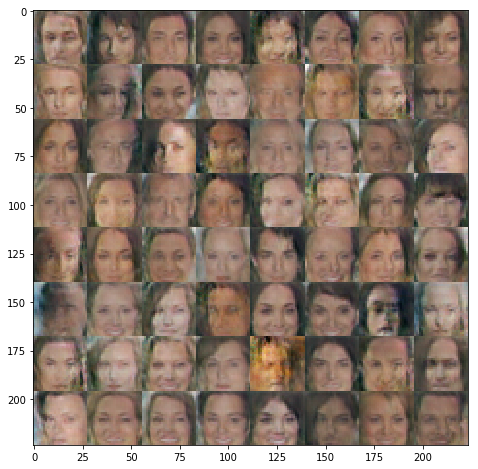

Epoch 0, batch 12050: discriminator loss 0.5565, generator loss 1.5889
Epoch 0, batch 12100: discriminator loss 0.4152, generator loss 1.5598
Epoch 0, batch 12150: discriminator loss 0.6524, generator loss 1.4328
Epoch 0, batch 12200: discriminator loss 0.3343, generator loss 2.0612
Epoch 0, batch 12250: discriminator loss 0.3694, generator loss 1.5808
Epoch 0, batch 12300: discriminator loss 0.5562, generator loss 1.3700
Epoch 0, batch 12350: discriminator loss 0.4640, generator loss 1.5269
Epoch 0, batch 12400: discriminator loss 0.3656, generator loss 1.8032
Epoch 0, batch 12450: discriminator loss 0.5396, generator loss 1.5127
Epoch 0, batch 12500: discriminator loss 0.3513, generator loss 1.6502


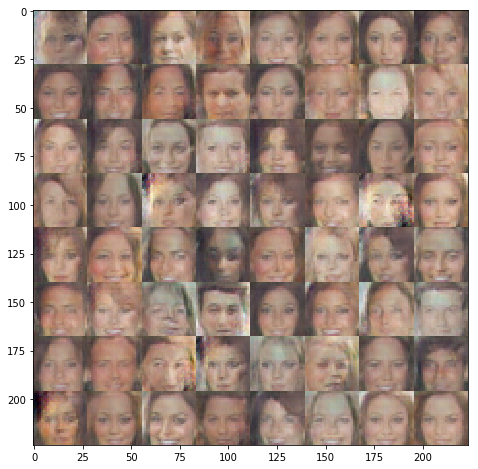

Epoch 0, batch 12550: discriminator loss 0.6085, generator loss 1.3303
Epoch 0, batch 12600: discriminator loss 0.2082, generator loss 2.0725
Epoch 0, batch 12650: discriminator loss 0.4246, generator loss 1.3897


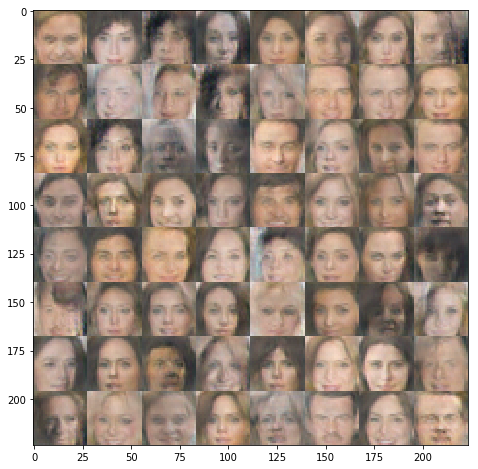

In [32]:
batch_size = 16
z_dim = 256
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.